In [50]:
import pandas as pd
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler


# Load the input_train data
input_train = pd.read_csv('input_train.csv')
input_train['binaryClass'] = input_train['binaryClass'].astype('category').cat.codes.values
input_train['pregnant'] = input_train['pregnant'].astype('category').cat.codes.values
input_train= input_train.drop('I131 treatment', axis=1)

In [51]:
input_train.head(20)

,TT4,FTI,T3,TSH,T4U,pregnant,binaryClass
0,46,79,0.3,0.88,0.58,0,1
1,165,184,2.5,0.4,0.9,0,1
2,136,114,2.6,0.6,1.19,0,1
3,122,108,?,2.4,1.12,0,1
4,121,104,2.7,2.7,1.17,0,1
5,103,95,?,0.005,1.08,0,1
6,109,118,1.8,0.77,0.92,0,1
7,91,82,1.8,5.1,1.12,0,1
8,118,83,2.9,0.43,1.42,0,1
9,117,107,?,2.1,1.09,0,1


In [52]:
def remove_outliers_rows(df, z_threshold=3, target_column=None):
    """
    Remove rows with outliers from a DataFrame.

    Parameters:
    - df (DataFrame): Input DataFrame.
    - z_threshold (float): Z-score threshold for outlier detection. Defaults to 3.
    - target_column (str): Name of the target label column to exclude from outlier removal. Defaults to None.

    Returns:
    - DataFrame: DataFrame with rows containing outliers removed.
    """
    df_copy = df.copy()  
    for column in df_copy.columns:
        if column == target_column:
            continue  # Skip outlier removal for the target class column
        # Convert column values to numeric, ignoring non-numeric values like '?'
        df_copy[column] = pd.to_numeric(df_copy[column], errors='coerce')
        z_scores = zscore(df_copy[column])
        outlier_indices = np.where(np.abs(z_scores) >= z_threshold)[0]
        df_copy = df_copy.drop(outlier_indices)
    
    return df_copy


def impute_missing_with_means(dataset, column, binary_class):
    dataset[column] = dataset[column].replace('?', np.nan)  # Replace '?' with NaN
    mean_1 = dataset[column].loc[(~dataset[column].isnull()) & (dataset['binaryClass'] == 1)].astype(float).mean().round(2)
    mean_0 = dataset[column].loc[(~dataset[column].isnull()) & (dataset['binaryClass'] == 0)].astype(float).mean().round(2)
    dataset.loc[(dataset[column].isnull()) & (dataset['binaryClass'] == 0), column] = mean_0
    dataset.loc[(dataset[column].isnull()) & (dataset['binaryClass'] == 1), column] = mean_1    

In [53]:
input_train = remove_outliers_rows(input_train, target_column='binaryClass')
input_train.describe(include='all')

,TT4,FTI,T3,TSH,T4U,pregnant,binaryClass
count,2786.000000,2662.000000,2356.000000,2681.000000,2660.000000,2969.0,2969.000000
mean,107.133955,110.049850,1.988514,5.231013,0.986069,0.0,0.921522
std,33.785153,31.619954,0.787786,25.017009,0.181536,0.0,0.268967
min,2.000000,2.000000,0.050000,0.005000,0.250000,0.0,0.000000
25%,87.000000,93.000000,1.600000,0.500000,0.870000,0.0,1.000000
50%,103.000000,107.000000,2.000000,1.400000,0.970000,0.0,1.000000
75%,123.750000,124.000000,2.300000,2.700000,1.080000,0.0,1.000000
max,372.000000,312.000000,8.500000,530.000000,2.320000,0.0,1.000000


In [54]:
input_train.head(20)

,TT4,FTI,T3,TSH,T4U,pregnant,binaryClass
0,46.0,79.0,0.3,0.880,0.58,0,1
1,165.0,184.0,2.5,0.400,0.90,0,1
2,136.0,114.0,2.6,0.600,1.19,0,1
3,122.0,108.0,NaN,2.400,1.12,0,1
4,121.0,104.0,2.7,2.700,1.17,0,1
5,103.0,95.0,NaN,0.005,1.08,0,1
6,109.0,118.0,1.8,0.770,0.92,0,1
7,91.0,82.0,1.8,5.100,1.12,0,1
8,118.0,83.0,2.9,0.430,1.42,0,1
9,117.0,107.0,NaN,2.100,1.09,0,1


In [55]:
columns_to_impute = ['TT4', 'FTI', 'T3', 'TSH', 'T4U']

for column in columns_to_impute:
    impute_missing_with_means(input_train, column, 'binaryClass')

In [56]:
input_train.describe(include='all')

,TT4,FTI,T3,TSH,T4U,pregnant,binaryClass
count,2969.000000,2969.000000,2969.000000,2969.000000,2969.000000,2969.0,2969.000000
mean,107.285864,110.126925,1.992920,4.913717,0.985630,0.0,0.921522
std,32.753518,30.103372,0.704132,23.791990,0.171847,0.0,0.268967
min,2.000000,2.000000,0.050000,0.005000,0.250000,0.0,0.000000
25%,88.000000,94.000000,1.700000,0.600000,0.890000,0.0,1.000000
50%,105.000000,110.000000,2.040000,1.600000,0.980000,0.0,1.000000
75%,122.000000,121.000000,2.200000,2.500000,1.060000,0.0,1.000000
max,372.000000,312.000000,8.500000,530.000000,2.320000,0.0,1.000000


In [57]:
input_train.head(20)

,TT4,FTI,T3,TSH,T4U,pregnant,binaryClass
0,46.00,79.00,0.30,0.880,0.58,0,1
1,165.00,184.00,2.50,0.400,0.90,0,1
2,136.00,114.00,2.60,0.600,1.19,0,1
3,122.00,108.00,2.04,2.400,1.12,0,1
4,121.00,104.00,2.70,2.700,1.17,0,1
5,103.00,95.00,2.04,0.005,1.08,0,1
6,109.00,118.00,1.80,0.770,0.92,0,1
7,91.00,82.00,1.80,5.100,1.12,0,1
8,118.00,83.00,2.90,0.430,1.42,0,1
9,117.00,107.00,2.04,2.100,1.09,0,1


In [58]:
input_train = input_train.dropna()

In [59]:
input_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2969 entries, 0 to 3016
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TT4          2969 non-null   float64
 1   FTI          2969 non-null   float64
 2   T3           2969 non-null   float64
 3   TSH          2969 non-null   float64
 4   T4U          2969 non-null   float64
 5   pregnant     2969 non-null   int8   
 6   binaryClass  2969 non-null   int8   
dtypes: float64(5), int8(2)
memory usage: 145.0 KB


In [60]:
input_train[input_train=='?'].count()

TT4            0
FTI            0
T3             0
TSH            0
T4U            0
pregnant       0
binaryClass    0
dtype: int64

In [61]:
input_train.drop_duplicates()

,TT4,FTI,T3,TSH,T4U,pregnant,binaryClass
0,46.0,79.0,0.30,0.88,0.58,0,1
1,165.0,184.0,2.50,0.40,0.90,0,1
2,136.0,114.0,2.60,0.60,1.19,0,1
3,122.0,108.0,2.04,2.40,1.12,0,1
4,121.0,104.0,2.70,2.70,1.17,0,1
...,...,...,...,...,...,...,...
3012,113.0,124.0,2.30,0.47,0.91,0,1
3013,110.0,101.0,2.70,2.40,1.09,0,1
3014,104.0,97.0,2.20,1.96,1.07,0,1
3015,128.0,129.0,1.60,0.50,0.99,0,1


In [62]:
input_train['binaryClass'].value_counts()

binaryClass
1    2736
0     233
Name: count, dtype: int64

In [63]:
# Define the parameter grid including sampling_strategy for SMOTE
param_grid = {
    'smote__k_neighbors': [5, 10, 15, 20],
    'smote__sampling_strategy': ['auto', 0.75, 1.0]
}

knn = KNeighborsClassifier()
smote = SMOTE()

pipeline = Pipeline([
    ('smote', smote),
    ('knn', knn)
])

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(input_train.drop('binaryClass', axis=1), input_train['binaryClass'])

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)


Best parameters: {'smote__k_neighbors': 20, 'smote__sampling_strategy': 0.75}


In [64]:
# Create the SMOTE object
smote = SMOTE(k_neighbors=best_params['smote__k_neighbors'], sampling_strategy=best_params['smote__sampling_strategy'])

# Apply SMOTE to balance the data
X_resampled, y_resampled = smote.fit_resample(input_train.drop('binaryClass', axis=1), input_train['binaryClass'])

balanced_data = pd.DataFrame(X_resampled, columns=input_train.drop('binaryClass', axis=1).columns)
balanced_data['binaryClass'] = y_resampled


In [65]:
# Create an instance of the RandomUnderSampler
undersampler = RandomUnderSampler()

# Apply undersampling to the balanced data
X_undersampled, y_undersampled = undersampler.fit_resample(balanced_data.drop('binaryClass', axis=1), balanced_data['binaryClass'])

# Create a new undersampled dataframe
balanced_data  = pd.DataFrame(X_undersampled, columns=balanced_data.drop('binaryClass', axis=1).columns)
balanced_data['binaryClass']  = y_undersampled

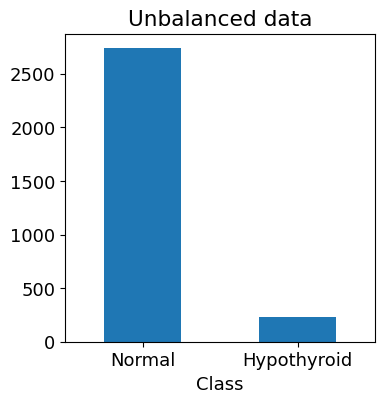

In [66]:
plt.rcParams.update({'font.size': 13})
# include figure 
plt.figure(figsize=(4, 4))
input_train['binaryClass'].value_counts().plot(kind='bar', title='Count (output)')
plt.xlabel('Class')
plt.title('Unbalanced data')
plt.xticks([0, 1], ['Normal', 'Hypothyroid'], rotation=0)
# save fig eps format
fig = plt.gcf()
#fig.savefig('unbalanced_data.eps', format='eps', dpi=600, bbox_inches='tight')

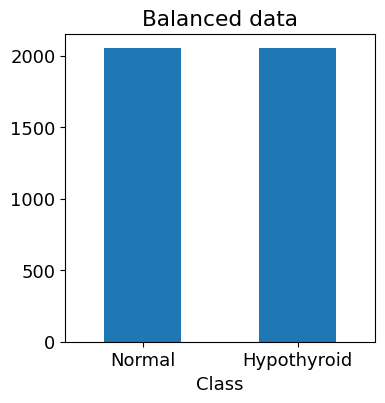

In [67]:
plt.rcParams.update({'font.size': 13})
# include figure 
plt.figure(figsize=(4, 4))
balanced_data['binaryClass'].value_counts().plot(kind='bar', title='Count (output)')
plt.xlabel('Class')
plt.title('Balanced data')
plt.xticks([0, 1], ['Normal', 'Hypothyroid'], rotation=0)
# save fig eps format
fig = plt.gcf()
#fig.savefig('unbalanced_data.eps', format='eps', dpi=600, bbox_inches='tight')

In [68]:
input_train[['TT4', 'FTI', 'T3', 'TSH', 'T4U']].describe()

,TT4,FTI,T3,TSH,T4U
count,2969.000000,2969.000000,2969.000000,2969.000000,2969.000000
mean,107.285864,110.126925,1.992920,4.913717,0.985630
std,32.753518,30.103372,0.704132,23.791990,0.171847
min,2.000000,2.000000,0.050000,0.005000,0.250000
25%,88.000000,94.000000,1.700000,0.600000,0.890000
50%,105.000000,110.000000,2.040000,1.600000,0.980000
75%,122.000000,121.000000,2.200000,2.500000,1.060000
max,372.000000,312.000000,8.500000,530.000000,2.320000


In [69]:
balanced_data[['TT4', 'FTI', 'T3', 'TSH', 'T4U']].describe()


,TT4,FTI,T3,TSH,T4U
count,4104.000000,4104.000000,4104.000000,4104.000000,4104.000000
mean,92.004650,93.360776,1.767618,18.572115,0.999647
std,37.342125,35.877531,0.709033,46.002064,0.159675
min,2.000000,2.000000,0.050000,0.005000,0.250000
25%,71.807911,73.084261,1.400000,1.400000,0.903000
50%,93.000000,96.000000,1.800000,6.276602,0.990000
75%,111.152400,113.290000,2.100000,12.828611,1.080650
max,372.000000,312.000000,8.500000,530.000000,2.320000


The mean and standard deviation of TSH have increased significantly after applying SMOTE. This increase suggests that the distribution of the TSH feature has been altered by the synthetic samples generated by SMOTE, resulting in a wider spread of values around the mean. The mean has shifted upwards, and the standard deviation has also increased, indicating greater variability in the data. This could be due to the synthetic samples introduced by SMOTE, which aim to better represent the minority class(es) and thus change the overall distribution of the dataset.

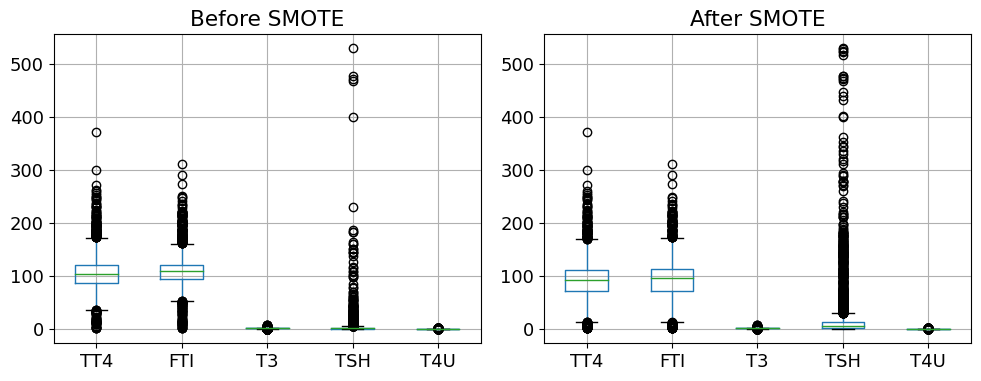

In [70]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
input_train__plot = input_train[['TT4', 'FTI', 'T3', 'TSH', 'T4U']]
input_train__plot.boxplot(ax=axes[0])
axes[0].set_title('Before SMOTE')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
input_train_plot = balanced_data[['TT4', 'FTI', 'T3', 'TSH', 'T4U']]
input_train_plot.boxplot(ax=axes[1])
axes[1].set_title('After SMOTE')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()


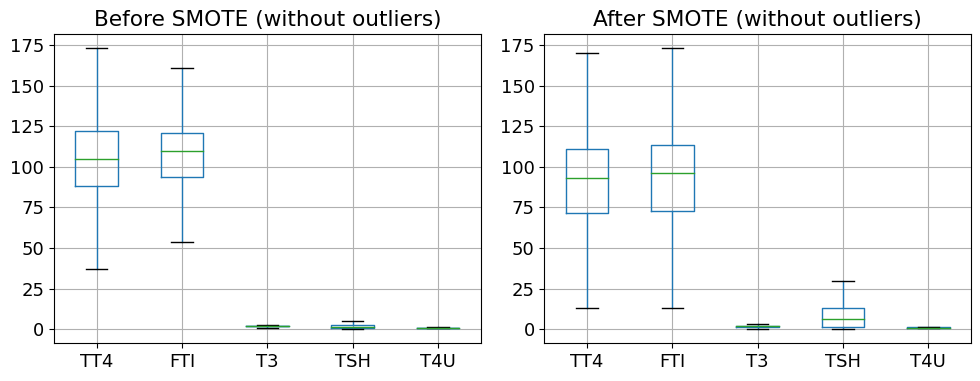

In [71]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
input_train__plot.boxplot(ax=axes[0], showfliers=False)
axes[0].set_title('Before SMOTE (without outliers)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
input_train_plot.boxplot(ax=axes[1], showfliers=False)
axes[1].set_title('After SMOTE (without outliers)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()


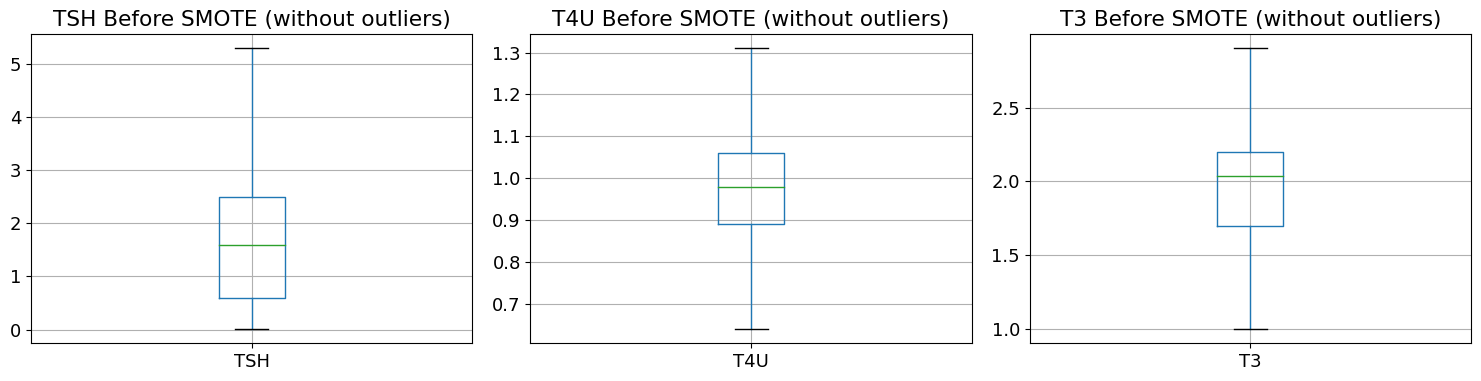

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
input_train__plot[['TSH']].boxplot(ax=axes[0], showfliers=False)
axes[0].set_title('TSH Before SMOTE (without outliers)')
axes[0].set_xticklabels(['TSH'], rotation=0)
input_train__plot[['T4U']].boxplot(ax=axes[1], showfliers=False)
axes[1].set_title('T4U Before SMOTE (without outliers)')
axes[1].set_xticklabels(['T4U'], rotation=0)
input_train__plot[['T3']].boxplot(ax=axes[2], showfliers=False)
axes[2].set_title('T3 Before SMOTE (without outliers)')
axes[2].set_xticklabels(['T3'], rotation=0)
plt.tight_layout()
plt.show()

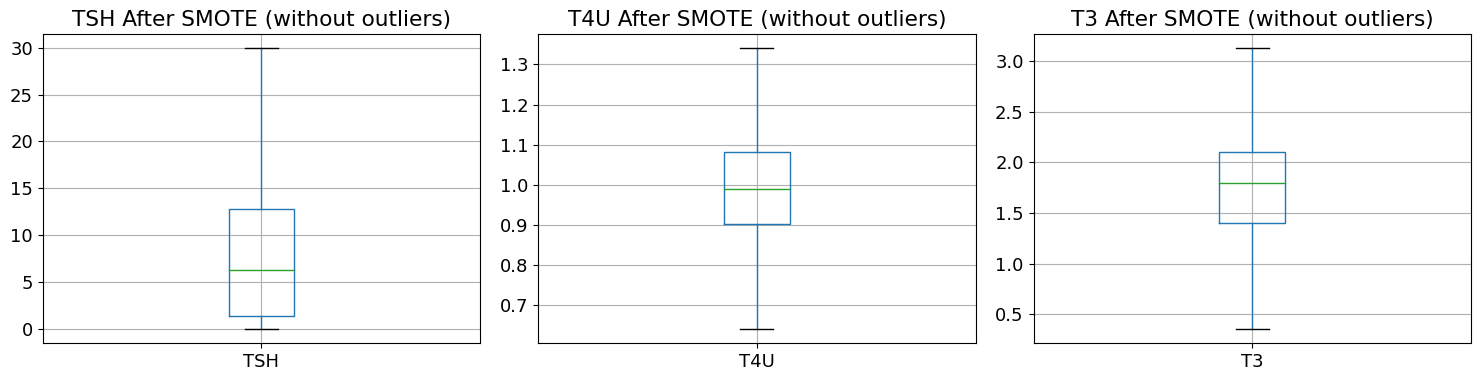

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
input_train_plot[['TSH']].boxplot(ax=axes[0], showfliers=False)
axes[0].set_title('TSH After SMOTE (without outliers)')
axes[0].set_xticklabels(['TSH'], rotation=0)
input_train_plot[['T4U']].boxplot(ax=axes[1], showfliers=False)
axes[1].set_title('T4U After SMOTE (without outliers)')
axes[1].set_xticklabels(['T4U'], rotation=0)
input_train_plot[['T3']].boxplot(ax=axes[2], showfliers=False)
axes[2].set_title('T3 After SMOTE (without outliers)')
axes[2].set_xticklabels(['T3'], rotation=0)
plt.tight_layout()
plt.show()

In [74]:
balanced_data.head()

,TT4,FTI,T3,TSH,T4U,pregnant,binaryClass
17,124.0,112.0,1.8,6.2,1.11,0,0
26,80.0,79.0,2.1,8.2,1.01,0,0
36,17.0,14.0,0.4,165.0,1.19,0,0
65,46.0,46.0,2.6,31.0,1.00,0,0
68,14.0,13.0,0.7,60.0,1.11,0,0


In [75]:
balanced_data.to_csv('intput_train_balanced.csv', index=False)